In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.stem import *
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime, timedelta, date
%matplotlib inline
plt.style.use('ggplot')

import nltk
import string

from nltk.corpus import stopwords
pstemmer = nltk.PorterStemmer()

In [62]:
y_col = 'variety_cleaned'

In [4]:
df = pd.read_csv('data/winemag-data-130k-v2.csv')

In [5]:
df.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
11883,11883,Italy,"Mature plum, nutmeg, new leather and thyme aro...",Dal Re,90,23.0,Southern Italy,Irpinia,NaN,Kerin O’Keefe,@kerinokeefe,Feudi di San Gregorio 2015 Dal Re Aglianico (I...,Aglianico,Feudi di San Gregorio
16197,16197,Argentina,The nose offers both minerally crispness and f...,NaN,90,22.0,Mendoza Province,Perdriel,NaN,Michael Schachner,@wineschach,Marchiori & Barraud 2012 Malbec (Perdriel),Malbec,Marchiori & Barraud
98385,98385,Austria,Ripe top notes of apricot and peach seduce rig...,Achleiten Smaragd,95,49.0,Wachau,NaN,NaN,Anne Krebiehl MW,@AnneInVino,Domäne Wachau 2013 Achleiten Smaragd Riesling ...,Riesling,Domäne Wachau
34837,34837,France,Vines on the slope of the Brouilly hill give a...,Les Cailloux,89,22.0,Beaujolais,Côte de Brouilly,NaN,Roger Voss,@vossroger,Emmanuel Fellot 2014 Les Cailloux (Côte de Br...,Gamay,Emmanuel Fellot
59648,59648,New Zealand,This boasts typical Marlborough characters of ...,NaN,85,15.0,Marlborough,NaN,NaN,Joe Czerwinski,@JoeCz,Dashwood 2013 Sauvignon Blanc (Marlborough),Sauvignon Blanc,Dashwood


In [6]:
repl_dir = {'petite sirah': 'syrah', 
            'shiraz': 'syrah', 
            'champagne' :'sparkling',
           }

In [10]:
df_nona = df.fillna('NA')

In [50]:
no_hyph = df_nona[df_nona['variety'].apply(lambda x: len(x.split('-')) < 2)]['variety'].str.lower()
no_hyph = no_hyph[no_hyph.apply(lambda x: x.split()[-1] != 'blend')].replace(repl_dir)

In [52]:
no_hyph.value_counts(1).head(20)

pinot noir            0.129946
chardonnay            0.115073
cabernet sauvignon    0.092740
syrah                 0.056278
riesling              0.050805
sauvignon blanc       0.048632
rosé                  0.034895
merlot                0.030372
nebbiolo              0.027454
zinfandel             0.026573
sangiovese            0.026504
malbec                0.025966
portuguese red        0.024145
tempranillo           0.017722
pinot gris            0.014246
cabernet franc        0.013247
grüner veltliner      0.013169
portuguese white      0.011348
pinot grigio          0.010300
gamay                 0.010036
Name: variety, dtype: float64

In [53]:
keep_vars = set(no_hyph.value_counts().head(16).index)

In [63]:
df[y_col] = df['variety'].replace(repl_dir)
df_noblends = df[df[y_col].replace(repl_dir).str.lower().isin(keep_vars)]

In [64]:
df_noblends[y_col].unique().size

16

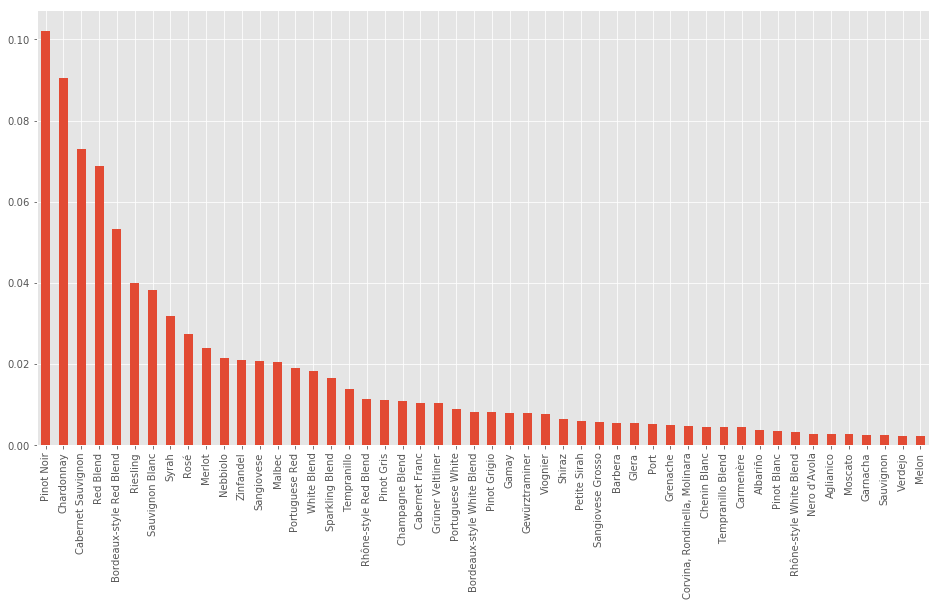

In [65]:
intr = df[y_col].value_counts(1).head(50)
plot = intr.plot(kind='bar', figsize=(16,8));
plot.set_xticklabels(intr.index, {'rotation' : 90});

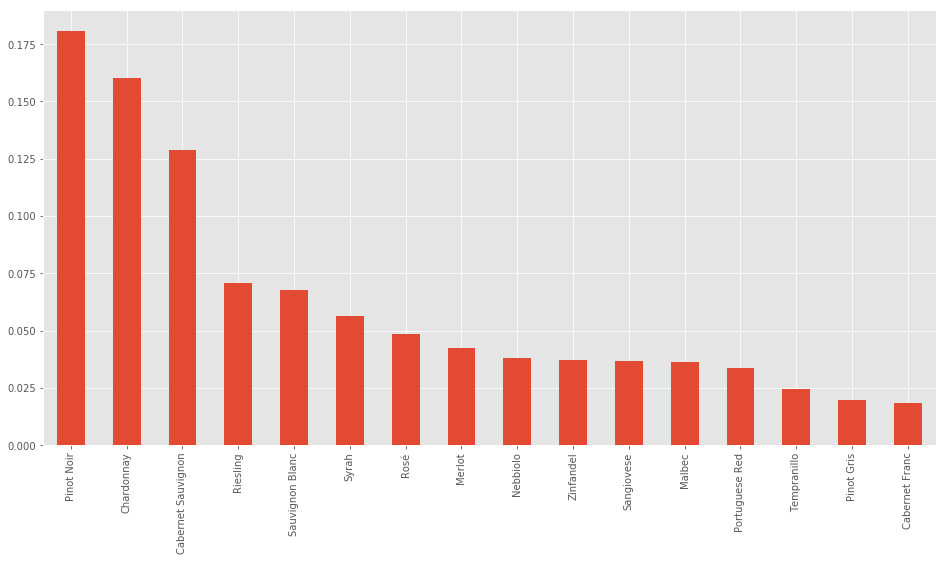

In [66]:
intr = df_noblends[y_col].value_counts(1)
plot = intr.plot(kind='bar', figsize=(16,8));
plot.set_xticklabels(intr.index, {'rotation' : 90});

In [67]:
df_noblends.description.sample(5).values

array([ "This wine's aromas of baked apple, honey, cinnamon and brown sugar are immediately attractive, and in the mouth it doesn't disappoint. It's broad and mouthfilling but avoids heaviness, finishing long, with hints of orange rind.",
       'One of the best Napa Cabernet Francs in memory, this shows lush, concentrated flavors of cherry pie, red currant, mocha, anise and smoky, spicy sandalwood that are wrapped into firm but exceptionally refined tannins. Drink now to experience the youthful beauty.',
       'Le Grillaie offers easy fruit tones of cherry and blackberry with touches of cola and licorice at the back. This simple red white would pair well with a heaping plate of pasta and meat sauce.',
       'The main estate wine from Roubine is a rich, ripe and fruity with a light edge of spice. It has a soft character, the result of the malolactic fermentation reducing the acidity. That gives a great balance between the red fruits and tangy zesty aftertaste. Drink now.',
       'Ju

In [68]:
# for i in df[df['variety'] == 'Nebbiolo']['description'].sample(50).values:
#     print(i)

In [76]:
### Take least represented of all values and take a sample of that size from the each group

min_val = df_noblends['variety'].value_counts().tail(1).values[0]

print(min_val)
list_of_dfs = []
for x in df_noblends[y_col].unique():
    list_of_dfs.append(df_noblends[df_noblends[y_col] == x].sample(min_val))
ndf = pd.concat(list_of_dfs)

In [82]:
ndf.shape

(21648, 16)

In [83]:
# df_nona = df[df[y_col].fillna('N') != 'N']
classif_varieties = set(ndf[y_col].unique())

In [85]:
label_map = {val: idx for idx, val in enumerate(ndf[y_col].unique())}

In [86]:
label_map

{'Cabernet Franc': 10,
 'Cabernet Sauvignon': 4,
 'Chardonnay': 5,
 'Malbec': 6,
 'Merlot': 7,
 'Nebbiolo': 14,
 'Pinot Gris': 1,
 'Pinot Noir': 3,
 'Portuguese Red': 0,
 'Riesling': 2,
 'Rosé': 11,
 'Sangiovese': 9,
 'Sauvignon Blanc': 8,
 'Syrah': 13,
 'Tempranillo': 15,
 'Zinfandel': 12}

In [132]:
y = ndf[y_col].replace(label_map).values

In [133]:
reviews = ndf.description

In [134]:
swords = set(stopwords.words('english'))

In [135]:
ps = PorterStemmer()

In [136]:
word_vecs = reviews\
    .apply(lambda x: [re.sub("[\W]", '', i).lower().strip() for i in x.split()])\
    .apply(lambda x: [ps.stem(i) for i in x if i not in swords and len(i) > 3])

In [137]:
word_vecs.sample(10)

108799    [chilli, 2011, vintag, kind, duttongoldfield, ...
129612    [foxi, jumpi, nose, candi, redberri, cherri, a...
47869     [dens, rich, ripe, tannic, structur, less, sal...
55575     [concentr, reduc, aroma, chocol, saucedrizzl, ...
52985     [love, syrah, mediumbodi, light, feel, velveti...
108248    [aroma, dark, plum, thistl, earth, captiv, sen...
82688     [good, good, wine, medicin, nose, take, aromat...
65587     [aroma, flower, graphit, licoric, highton, her...
111863    [usual, wine, offer, solid, berri, fruit, arom...
129324    [almost, pale, color, rosé, pinot, light, silk...
Name: description, dtype: object

In [138]:
back2sent = word_vecs.apply(lambda x: ' '.join(x))

In [139]:
transform = TfidfVectorizer(lowercase=False, min_df=.05)

In [140]:
tf_idf_matrix = transform.fit_transform(back2sent.values)

In [141]:
## build train_test_split
test_train = np.random.random(word_vecs.shape[0]) < .8
Xtr = tf_idf_matrix[test_train]
Xte = tf_idf_matrix[~test_train]
ytr = y[test_train]
yte = y[~test_train]

In [142]:
from sklearn.naive_bayes import GaussianNB

In [143]:
start = datetime.now()
modelgb = GaussianNB()
modelgb.fit(Xtr.toarray(), ytr)
print(modelgb.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.280697830463
0


In [144]:
from sklearn.svm import SVC

In [145]:
start = datetime.now()
model_svm = SVC(C=1.0, kernel='rbf', degree=3, gamma=.05)
model_svm.fit(Xtr.toarray(), ytr)
print( model_svm.score(Xte.toarray(), yte))
print((datetime.now()-start).seconds)

0.415566987251
38


In [146]:
from sklearn.ensemble import RandomForestClassifier

In [147]:
start = datetime.now()
modelrf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
modelrf.fit(Xtr.toarray(), ytr)
print(modelrf.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.447774547081
13


In [148]:
## run this line if needed xgboost is not a part of Sklearn
## we could also use GradientBoostingClassifier, but since it does not support 
## parallel processing, and XGboost typically gives near the same performance
## we will use XGboost
#!pip install xgboost

In [149]:
import xgboost as xgb

In [150]:
start = datetime.now()
modelxg3 = xgb.XGBClassifier(max_depth=3, learning_rate=.05, n_estimators=250, n_jobs=-1)
modelxg3.fit(Xtr.toarray(), ytr)
print(modelxg3.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.411317378662
36


In [151]:
start = datetime.now()
modelxg5 = xgb.XGBClassifier(max_depth=5, learning_rate=.05, n_estimators=250, n_jobs=-1)
modelxg5.fit(Xtr.toarray(), ytr)
print(modelxg5.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.429434131067
63


In [152]:
start = datetime.now()
modelxg_lr1 = xgb.XGBClassifier(max_depth=5, learning_rate=.1, n_estimators=250, n_jobs=-1)
modelxg_lr1.fit(Xtr.toarray(), ytr)
print(modelxg_lr1.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.435920375755
61


In [153]:
start = datetime.now()
modelxg_t1000 = xgb.XGBClassifier(max_depth=5, learning_rate=.1, n_estimators=250, n_jobs=-1)
modelxg_t1000.fit(Xtr.toarray(), ytr)
print(modelxg_t1000.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.435920375755
62


In [127]:
# dense_matrix = pd.DataFrame(tf_idf_matrix.todense())

# ## these may be in order of count, not the orde of the columns so this is were i messed up
# dense_matrix.columns = [v for v in transform.vocabulary_.keys()]

# dense_matrix.columns

# dense_matrix.sample(10)

# country_dm = dense_matrix.copy()

# country_dm['y'] = df['country']

In [128]:
start = datetime.now()
#process things
print((datetime.now() - start).seconds)

0
